In [1]:
import pandas as pd
import glob
import os
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from scipy import signal
import pdb
import time
import calendar
import pyfftw
from comb_utils import *
from tqdm.notebook import tqdm


In [2]:
class coupled_rings(microring):
    '''class for coupled microrings'''
    def __init__(self,A,B,match_idx,proximity=5,QcAB_file='coupling_q_2.csv',seed=None):
        # A is the soliton ring, B is the auxiliary ring
        # since normalization needs to be consistent, here we normalize everything to the external and intrinsic loss rate of cavity A
        # underscore in front of the variable means it has been fftshifted.
        ####################################
        ####################################
        # static arrays for computation
        self.A = A
        self.B = B
        self.AatBmask = self.transfer_mask(A,B) # len of B
        self.BatAmask = self.transfer_mask(B,A) # len of A
        assert(len(self.AatBmask)==B.Nmodes); assert(len(self.BatAmask)==A.Nmodes)
        self.match_idx = match_idx # this is the mode that is matched with the center of B. This index is used for when there is detuning between the mode pair
        self._DintA = self.A.Dint_arr # shifted so that the pump frequency is at the 0th position, underscore in the front to indicate shifted
        self._DintB = self.B.Dint_arr
        
        ####################################
        # set detunings from mode of the mode-mode interactions
        self.get_phaseDiffs(A,B,proximity)
        
        ####################################
        # set total effective detunings
        self._ΦA = self._DintA # + self.A.fftshift(self.ΔA,self.A.idx)
        self._ΦB = self._DintB # + self.B.fftshift(self.ΔB,self.B.idx)
        
        ####################################
        # set effective coupling rates
        self.QcA = self.get_QcAB(QcAB_file,self.A.ωarr) # in the perspective of A modes
        self.QcB = self.get_QcAB(QcAB_file,self.B.ωarr) # in the perspective of B modes
        self.plot_QcAB()
        self.ΔωAB_A, self._ΔωAB_A = self.A.ωarr/self.QcA,self.A.fftshift(self.A.ωarr/self.QcA,A.idx) # coupling rate from A to B at A modes
        self.ΔωBA_B, self._ΔωBA_B = self.B.ωarr/self.QcB,self.B.fftshift(self.B.ωarr/self.QcB,B.idx) # coupling rate from B to A at B modes
        
        self._ξA = (self.A.Δωext + self._ΔωAB_A + self.A.Δωi)/self.A.Δωtot # self.A.Δωext has already been shifted
        try:
            self._ξB = B.fftshift((self.ΔωBA_B + self.B.Δωi)/self.A.Δωtot,B.idx)
        except:
            self._ξB = (self.B.Δωext + self.B.Δωi)/self.A.Δωtot # normalization needs to be consistent (self.A.Δωext + self.A.Δωi)/self.A.Δωtot#
        
        ####################################
        # pump, noise, and initialize solution array (static).  Separate solution arrays for A and B
        self._Farr = np.linspace(0,0,A.Nmodes,dtype='complex')
        self._Farr[0] = A.F_arr[0]
        print(f'Soliton ring pumped at F^2 = {np.abs(self._Farr[0])**2}')
        self.solA = np.ndarray(shape=(A.Nsnapshots, A.Nmodes), dtype='complex')
        self.solB = np.ndarray(shape=(A.Nsnapshots, B.Nmodes), dtype='complex')
        self._noiseA = A.set_noise(seed=seed) # shifted noise array
        self._noiseB = B.set_noise(seed=seed)
        self.solA[0,:]=self._noiseA
        self.solB[0,:]=self._noiseB
        # dynamic arrays can be utilized within the split-step method
        
        ####################################
        
    def get_phaseDiffs(self,A,B,proximity):
        '''There are two terms that we need to account for in terms of the mode interactions
        1. B to A coupling in the perspective of A modes
            - Here, B modes act as pump terms and will be located precisely at ωarr, an equidistant frequency grid.
            The detunings will be different from the FWM terms, and since we are in the frame reference of B.ω0,
            the variation of specific modes described by the LLE-A will incur a time dependent coupling term from B.
            - This array needs to be something like: (B.ωarr - A.ωarr_adjusted[BtoAmask]) but with the length of A
        2. A to B coupling in the perspective of B modes
            Same as above: (A.ωarr - B.ωarr_adjusted[BtoAmask]) but with the length of A
            
            Phase arrays will contain information about the detuning of effective pump modes from the actual '''
        ####################################
        # find phase array for LLE-A
        self.ΔA = self.A.ωarr_adjusted - self.B.ωarr[self.BatAmask] # -self.B.ωarr_adjusted[self.BatAmask]
        self._ΔA = A.fftshift(self.ΔA,A.idx)
        self.ΔAmask = (np.abs(self.ΔA)<np.abs(proximity*self.A.Δωtot))*1 # indicates which tones are within a reasonable number of linewidths away to be included in calculations
        print(f"{np.sum(np.abs(self.ΔAmask))} coincidences in A's perspective")
        self.ΔA_selected, self._ΔA_selected = self.ΔA*self.ΔAmask, self._ΔA*A.fftshift(self.ΔAmask,A.idx)
        self.Aphase_arr = np.exp(1j*self.ΔA_selected)*self.ΔAmask # may need to check the sign of the phase in the future
        self._Aphase_arr = np.exp(1j*self._ΔA_selected)*A.fftshift(self.ΔAmask,A.idx)
        assert((self.Aphase_arr==A.ifftshift(self._Aphase_arr,A.idx)).all())
        
        ####################################
        # find phase array for LLE-B
        self.ΔB = self.B.ωarr_adjusted-self.A.ωarr[self.AatBmask]
        self._ΔB = A.fftshift(self.ΔB,B.idx)
        self.ΔBmask = (np.abs(self.ΔB)<np.abs(proximity*self.A.Δωtot))*1
        print(f"{np.sum(np.abs(self.ΔBmask))} coincidences in B's perspective")
        self.ΔB_selected, self._ΔB_selected = self.ΔB*self.ΔBmask, self._ΔB*B.fftshift(self.ΔBmask,B.idx)
        self.Bphase_arr = np.exp(1j*self.ΔB_selected)*self.ΔBmask
        self._Bphase_arr = np.exp(1j*self._ΔB_selected)*B.fftshift(self.ΔBmask,B.idx)
        assert((self.Bphase_arr==B.ifftshift(self._Bphase_arr,B.idx)).all())

    
    def get_QcAB(self,QcAB_file,ωarr):
        '''given frequency array, return the corresponding coupling Q
        ΔωAB_file is in [lambda,Qc] format'''
        self.df_QcAB = pd.read_csv(QcAB_file)
        df_QcAB_coeffs = np.polyfit(3e2/self.df_QcAB['lambda'],self.df_QcAB['Qc'],deg=12)
        return self.PolyCoefficients(ωarr/1e12,df_QcAB_coeffs)
    
    def plot_QcAB(self):
        fig, ax = plt.subplots(1,2,figsize=(9,2))
        ax[0].plot(A.ωarr/1e12,np.log10(self.QcA))
        ax[0].plot(3e2/self.df_QcAB['lambda'],np.log10(self.df_QcAB['Qc']))
        ax[0].set_xlabel('Frequency (THz)')
        ax[0].set_ylabel('QcA (Log10)')
        ax[1].plot(B.ωarr/1e12,np.log10(self.QcB))
        ax[1].plot(3e2/self.df_QcAB['lambda'],np.log10(self.df_QcAB['Qc']))
        ax[1].set_xlabel('Frequency (THz)')
        ax[1].set_ylabel('QcB (Log10)')
        fig.tight_layout()
        plt.show()
    
    def split_step(self,threads=1,wisdom=None):
        '''split step method of the coupled ring resonators, with most of the simulation parameters defined
        by the soliton ring resonator'''
        with tqdm(total=self.A.Nsnapshots) as pbar:
            divbysnapshot = self.A.Nsim//self.A.Nsnapshots
            sol_track = 0
            ψfA = self.solA[0,:]
            ψfB = self.solB[0,:]
            assert(len(ψfB)==self.B.Nmodes); assert(len(ψfA)==self.A.Nmodes)
            _Farr = np.fft.ifft(self._Farr)*(self.A.Nmodes) # time domain
            ψfA += self._Farr*self.A.Nmodes*self.A.dt
            
            ####################################
            # Convert to local variables
            Nsnapshots = self.A.Nsnapshots
            dt = self.A.dt
            AatBmask = self.AatBmask # defines which A mode at B
            BatAmask = self.BatAmask
            Δωtot = self.A.Δωtot
            _ΔωAB_A = self._ΔωAB_A
            _ΔωBA_B = self._ΔωBA_B
            Aδarr = self.A.δarr + (self.B.ω0 - self.A.ωarr[self.match_idx]) # check sign
            print(f"initial detuning between A/B mode pair = {(self.B.ω0 - self.A.ωarr[self.match_idx])/1e9} GHz")
            _ΦA = self._ΦA
            _ΦB = self._ΦB
            _ξA = self._ξA
            _ξB = self._ξB
            _Aphase_arr = self._Aphase_arr
            _Bphase_arr = self._Bphase_arr
            _ΔAmask = self.A.fftshift(self.ΔAmask,self.A.idx) # array of 1's and 0's that defines in proximity or not
            _ΔBmask = self.B.fftshift(self.ΔBmask,self.B.idx)
            _ΔA_selected = self._ΔA_selected*2/Δωtot # phases that are selected the ones not selected are 0 (normalized)
            _ΔB_selected = self._ΔB_selected*2/Δωtot
            _noiseA = self._noiseA
            _noiseB = self._noiseB
            t = 0
            
            ####################################
            # Plan FFT/iFFT
            ψfA_ifft = pyfftw.empty_aligned(self.A.Nmodes,dtype='complex128',n=16) # frequency domain, named ifft_arr because we have to perform ifft after seeing this arr
            ψA_fft = pyfftw.empty_aligned(self.A.Nmodes,dtype='complex128',n=16) # time domain
            A_fftobj = pyfftw.FFTW(ψA_fft,ψfA_ifft,threads=threads,flags=('FFTW_MEASURE',))
            A_ifftobj = pyfftw.FFTW(ψfA_ifft,ψA_fft,direction='FFTW_BACKWARD',threads=threads,flags=('FFTW_MEASURE',))
            ψfA_ifft[:] = ψfA
            
            ψfB_ifft = pyfftw.empty_aligned(self.B.Nmodes,dtype='complex128',n=16) # frequency domain, named ifft_arr because we have to perform ifft after seeing this arr
            ψB_fft = pyfftw.empty_aligned(self.B.Nmodes,dtype='complex128',n=16) # time domain
            B_fftobj = pyfftw.FFTW(ψB_fft,ψfB_ifft,threads=threads,flags=('FFTW_MEASURE',))
            B_ifftobj = pyfftw.FFTW(ψfB_ifft,ψB_fft,direction='FFTW_BACKWARD',threads=threads,flags=('FFTW_MEASURE',))
            ψfB_ifft[:] = ψfB
            
            if wisdom:
                pyfftw.import_wisdom(wisdom)
            
            ####################################
            # Compute coupled rings split step
            for i in range(int(self.A.Nsim)):
                ADisp = np.exp( (-dt/2) * 
                               (1j*(2*(_ΦA + Aδarr[i])/Δωtot + 
                                    np.exp(1j*_ΔA_selected*t)*_ΔAmask*_ΔωAB_A*ψfB_ifft[BatAmask]*2/Δωtot/ψfA_ifft) +
                                _ξA) ) # _Aphase_arr*
                BDisp = np.exp( (-dt/2) * 
                               (1j*(2*(_ΦB + Aδarr[i])/Δωtot + 
                                    np.exp(1j*_ΔB_selected*t)*_ΔBmask*_ΔωBA_B*ψfA_ifft[AatBmask]*2/Δωtot/ψfB_ifft) + 
                                _ξB) ) # _Bphase_arr*
                ψfA_ifft[:], ψfB_ifft[:] = ADisp * ψfA_ifft, BDisp * ψfB_ifft
                A_ifftobj(); B_ifftobj()
                ψA_fft[:] = np.exp(dt *(1j *  np.abs(ψA_fft) ** 2 + _Farr/ψA_fft)) * ψA_fft
                ψB_fft[:] = np.exp(dt *(1j *  np.abs(ψB_fft) ** 2)) * ψB_fft
                A_fftobj(); B_fftobj()
                ψfA_ifft[:], ψfB_ifft[:] = ADisp * ψfA_ifft, BDisp * ψfB_ifft
                ψfA_ifft += _noiseA; ψfB_ifft += _noiseB
                t += dt
                
                if (not((i+1)%divbysnapshot)) and sol_track<Nsnapshots:
                    self.solA[sol_track,:] = ψfA_ifft
                    self.solB[sol_track,:] = ψfB_ifft
                    sol_track += 1
                    pbar.update(1)
                    
    def transfer_mask(self,A,B):
        '''define function that assigns a corresponding spectrally closest A mode that acts as 
        a pump mode for each B mode, the return is a length of B. This function is general.'''
        ωA = A.ωarr # A.fftshift(A.ωarr_adjusted,A.idx)
        ωB = B.ωarr_adjusted# B.fftshift(B.ωarr_adjusted,B.idx)
        Aidx = 0
        mask = []
        for ωb in ωB:
            currDiff = np.abs(ωA[Aidx]-ωb)
            while np.abs(ωA[Aidx]-ωb)<=currDiff:
                currDiff = np.abs(ωA[Aidx]-ωb)
                Aidx += 1 
                if Aidx == len(ωA):
                    break
            Aidx -= 1
            mask.append(Aidx) # mask of A, which A mode as pump for B
        return np.array(mask)
    
    

In [62]:
Aparams = {
	'R': 25e-6,
	'height': 1e-6,
	'width': 2.3e-6,
	'pump': 50e-3,
	'Nmodes': 2**8,
	'Qc': 1e6,
	'Qi': 1e6,
	'ng': 2.2,
	'n2': 2.4e-19,
	'δnorm_range': [-8,20],
	'ω_range': [],
	'λ_range': [],
	'ω0': 3e8/1.550e-6,
	'λ0': None,
	'total_time': 1e-6,
	'dt': 1e-3/2,
	'ω_sweep_speed': None,
	'λ_sweep_speed': None,
	'Qc_import': 10**np.linspace(5.0,7.0,2**8),
	'Dint_file': '2.300w_58.5r_0.960h.csv',
	'snapshots': 2000,
	'mode_offset': 0,
	'Dint_degrees': 9
}

ω_start = 193.41602939368178 THz, ω_end = 193.41063812869876 THz
λ_start = 1549.987655830728 nm, λ_end = 1550.0308612834056 nm
normalized detunings = [ -8 , 20 ] (relevant parameters: δnorm_range)
sweep speed (ω space) = 5391264.98303125 GHz/s 
sweep speed (λ space) = 43205.45267761931 nm/s
real time = 1e-06, normalized time = 192.54517796539992 (relevant parameters: total_time), dt = 0.0005
Simulation points = 25672690.0 (relevant parameters: dt)
detuning at start = -1.54036142371875 GHz, detuning at end = 3.8509035593125 GHz (relevant parametes: ω_range, λ_range)
polynomial of order 9.
normalized external coupling rate at pump = 0.9910109002566694
g0 = 1.0199359714377958, Veff = 3.6128315516282617e-16, F^2 = 42.739296193844176


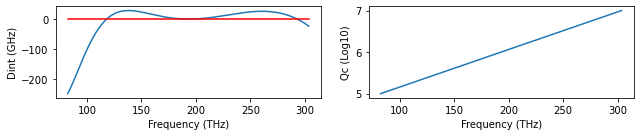

1.9977919823284824e-06
1.9981018894396825e-06
ω_start = 150.03982425727747 THz, ω_end = 150.0356231758069 THz
λ_start = 1998.0859047524445 nm, λ_end = 1998.141852276728 nm
normalized detunings = [ -8 , 20 ] (relevant parameters: δnorm_range)
sweep speed (ω space) = 4201081.4705625 GHz/s 
sweep speed (λ space) = 55947.52428351356 nm/s
real time = 1e-06, normalized time = 150.03862394828587 (relevant parameters: total_time), dt = 0.001
Simulation points = 10002574.0 (relevant parameters: dt)
detuning at start = -1.20030899159375 GHz, detuning at end = 3.00077247896875 GHz (relevant parametes: ω_range, λ_range)
polynomial of order 9.
g0 = 0.3151017871047167, Veff = 7.037167544041137e-16, F^2 = 28.158895440281686


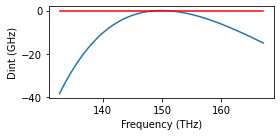

In [60]:
A = microring(R=25e-6,height=1e-6,width=2.3e-6,ng=2.2,Qc=1e6,Qi=1e6,n2=2.4e-19,
                δnorm_range=[-8,20],ω_range=[],λ_range=[],ω0=299792458/1.550e-6,λ0=None,
                total_time=1e-6,ω_sweep_speed=None,λ_sweep_speed=None,Qc_import=10**np.linspace(5.0,7.0,2**8),
                Dint_file='2.300w_58.5r_0.960h.csv',dt=1e-3/2,
                Nmodes=2**8,pump=200e-3,snapshots=2000,mode_offset=0,Dint_degrees=9)

numModes = 2**7
idx = 78

print(299792458/A.ωarr_adjusted[idx])
print(299792458/A.ωarr[idx])
B = microring(R=80e-6,height=1e-6,width=1.4e-6,ng=2.2,Qc=1e6,Qi=1e6,n2=2.4e-19,
                δnorm_range=[-8,20],ω_range=[],λ_range=[],ω0=A.ωarr[idx],λ0=None,
                total_time=1e-6,ω_sweep_speed=None,λ_sweep_speed=None,Dint_file='new_shg_100R_1umto2um.csv',dt=1e-3,
                Nmodes=numModes,pump=200e-3,snapshots=2000,mode_offset=0,Dint_degrees=9)


28 coincidences in A's perspective
11 coincidences in B's perspective
polynomial of order 12.
polynomial of order 12.


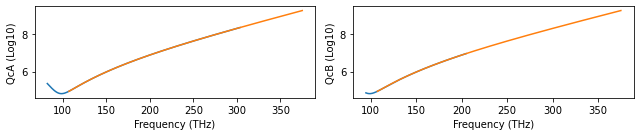

Soliton ring pumped at F^2 = 42.739296193844176


In [59]:
coupledAB05 = coupled_rings(A,B,match_idx=idx,seed=10) # higher power

0 coincidences in A's perspective
3 coincidences in B's perspective
polynomial of order 12.
polynomial of order 12.


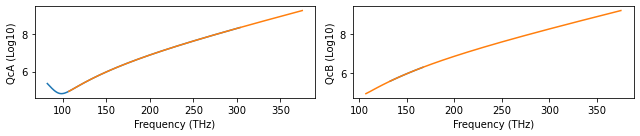

Soliton ring pumped at F^2 = 42.739296193844176


In [45]:
coupledAB04 = coupled_rings(A,B,match_idx=idx,seed=10) # higher power

In [46]:
coupledAB04.split_step()

  0%|          | 0/2000 [00:00<?, ?it/s]

initial detuning between A/B mode pair = 0.0 GHz


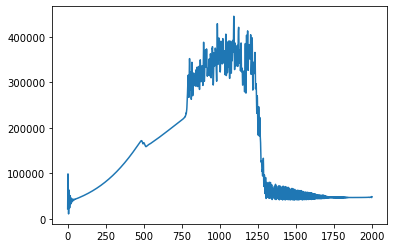

In [48]:
plt.plot(np.sum(np.abs(coupledAB04.solA[:])**2,axis=1))

In [50]:
A.sol = coupledAB04.solA
B.sol = coupledAB04.solB

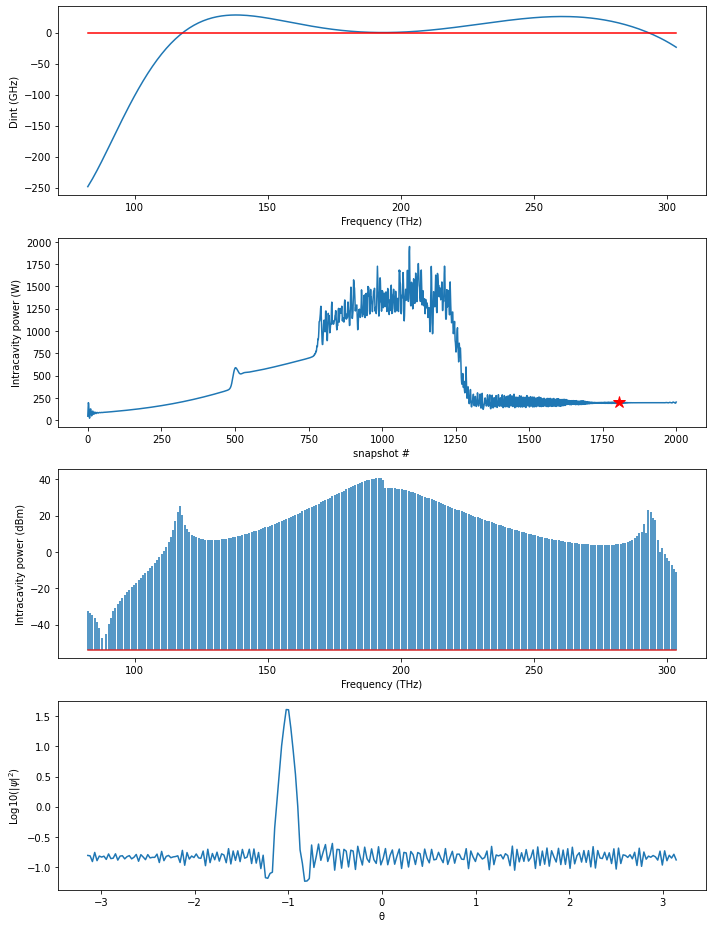

In [51]:
A.plot_all()

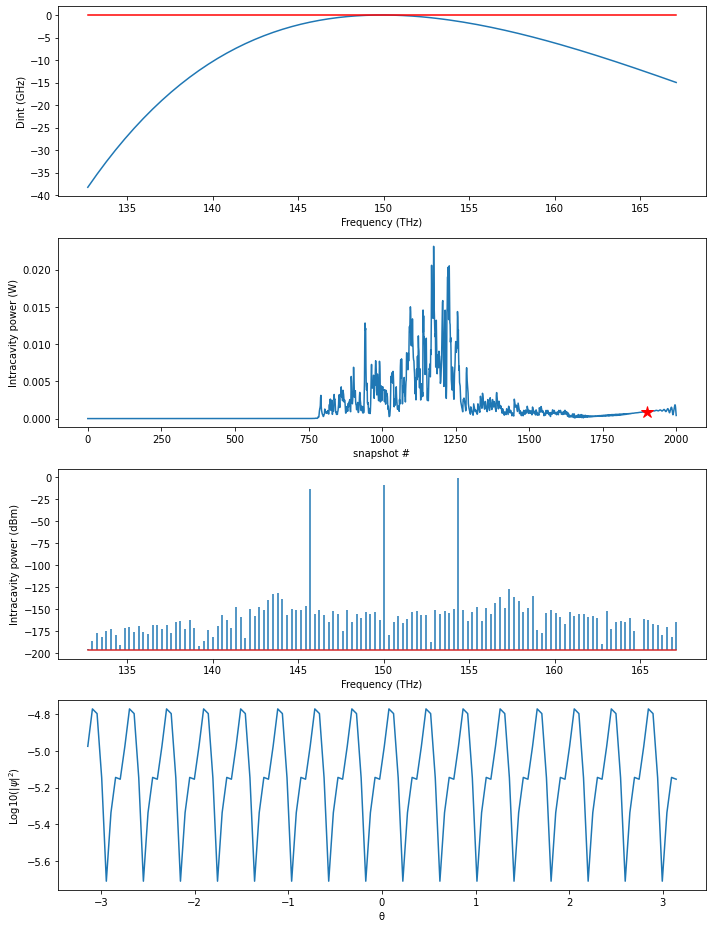

In [53]:
B.plot_all(1900)

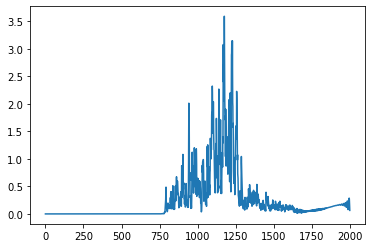

In [49]:
plt.plot(np.sum(np.abs(coupledAB04.solB[:])**2,axis=1))

0 coincidences in A's perspective
3 coincidences in B's perspective
polynomial of order 12.
polynomial of order 12.


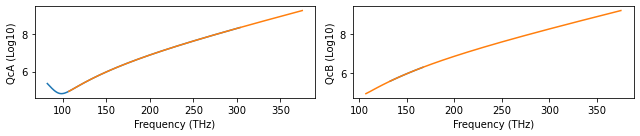

Soliton ring pumped at F^2 = 10.684824048461044


In [41]:
coupledAB3 = coupled_rings(A,B,match_idx=idx,seed=10)

In [42]:
coupledAB3.split_step()

  0%|          | 0/2000 [00:00<?, ?it/s]

initial detuning between A/B mode pair = 0.0 GHz


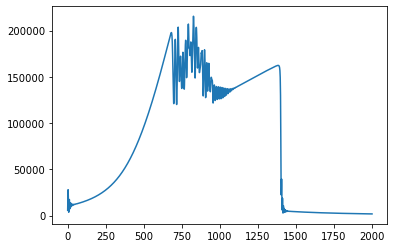

In [43]:
plt.plot(np.sum(np.abs(coupledAB3.solA[:])**2,axis=1))

0 coincidences in A's perspective
3 coincidences in B's perspective
polynomial of order 12.
polynomial of order 12.


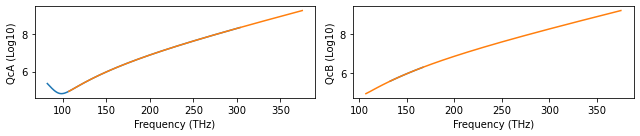

Soliton ring pumped at F^2 = 10.684824048461044


In [30]:
coupledAB2 = coupled_rings(A,B,match_idx=idx,seed=10)

In [31]:
coupledAB2.split_step()

  0%|          | 0/2000 [00:00<?, ?it/s]

initial detuning between A/B mode pair = 0.0 GHz


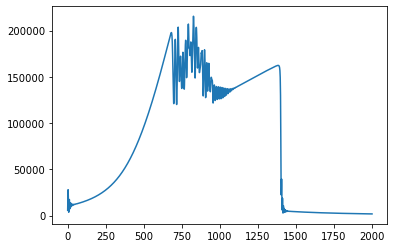

In [18]:
plt.plot(np.sum(np.abs(coupledAB.solA[:])**2,axis=1))

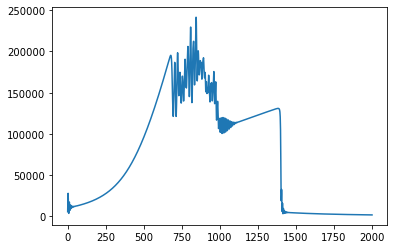

In [27]:
plt.plot(np.sum(np.abs(coupledAB.solA[:])**2,axis=1))

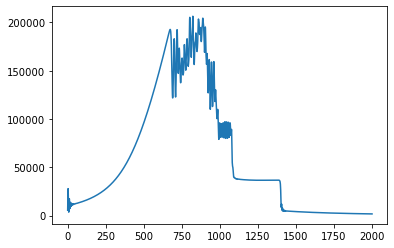

In [32]:
plt.plot(np.sum(np.abs(coupledAB2.solA[:])**2,axis=1))

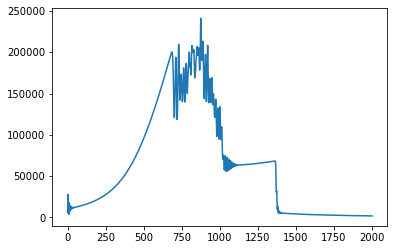

In [8]:
plt.plot(np.sum(np.abs(coupledAB.solA[:])**2,axis=1))

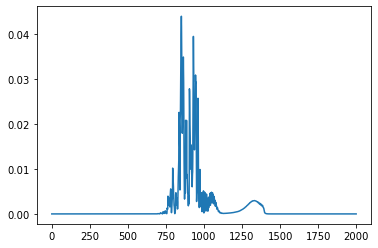

In [19]:
plt.plot(np.sum(np.abs(coupledAB.solB[:])**2,axis=1))

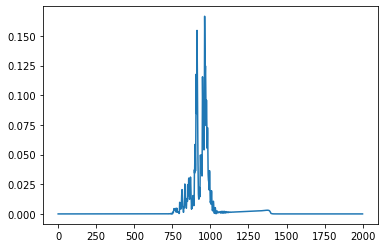

In [28]:
plt.plot(np.sum(np.abs(coupledAB.solB[:])**2,axis=1))

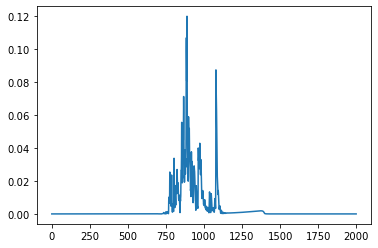

In [33]:
plt.plot(np.sum(np.abs(coupledAB2.solB[:])**2,axis=1))

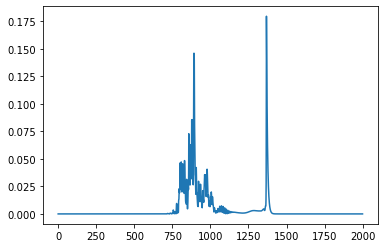

In [9]:
plt.plot(np.sum(np.abs(coupledAB.solB[:])**2,axis=1))

In [34]:
A.sol = coupledAB.solA

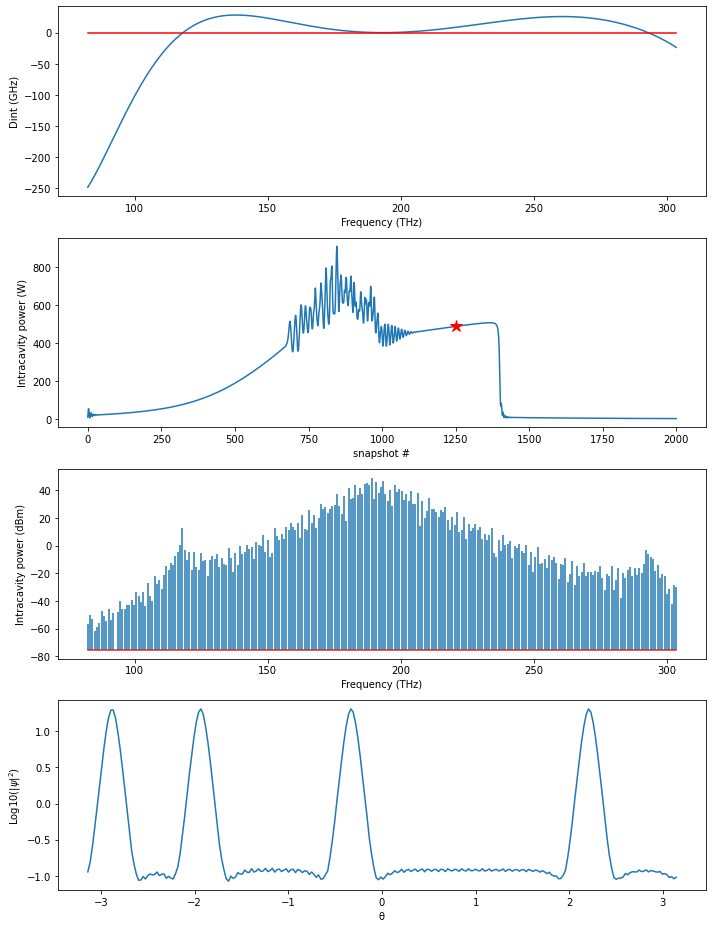

In [35]:
A.plot_all(1250)

In [47]:
B.sol = coupledAB2.solB

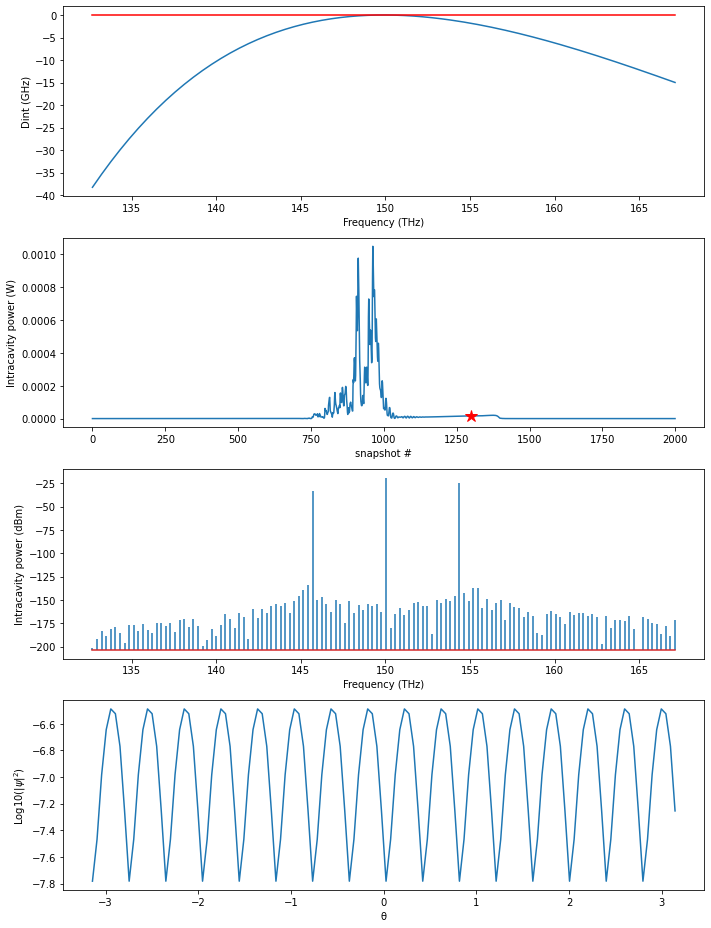

In [37]:
B.plot_all(1300)

In [38]:
B.sol = coupledAB2.solB

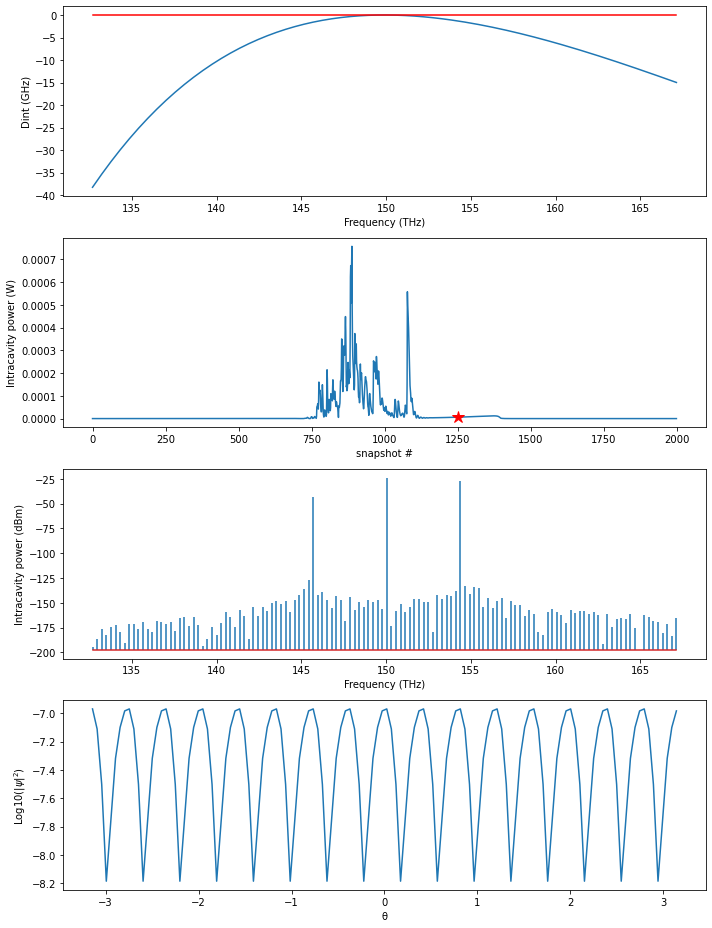

In [39]:
B.plot_all(1250)

In [80]:
import pickle

In [77]:
os.path.basename(os.getcwd())

'20210522'

In [65]:
os.getcwd()

'/home/suryajb/research/comb/simulations/20210522'

In [83]:
def save_obj(obj, name ):
    with open(os.getcwd() + '/' + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(os.getcwd() + '/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

<AxesSubplot:>

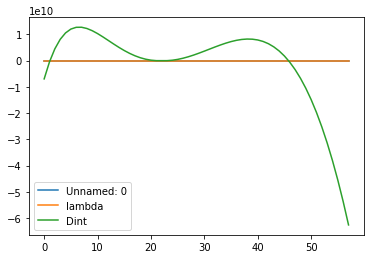

In [55]:
pd.read_csv('2.500w_58.5r_0.960h.csv').plot()